# Análisis de Texto en Python: Bag of Words (Bolsa de Palabras)

* * * 

<div class="alert alert-success">  
    
### Objetivos de Aprendizaje
    
* Aprender cómo convertir datos de texto en números mediante el enfoque Bag-of-Words (Bolsa de Palabras).
* Comprender el algoritmo TF-IDF y cómo complementa la representación Bag-of-Words.
* Implementar Bag-of-Words y TF-IDF usando el paquete `sklearn` y entender sus parámetros de configuración.
* Utilizar las representaciones numéricas de datos de texto para realizar análisis de sentimientos.
</div>

### Iconos Utilizados en Este Cuaderno
🔔 **Pregunta**: Una pregunta rápida para ayudarte a entender lo que está pasando.<br>
🥊 **Desafío**: Ejercicio interactivo. ¡Trabajaremos en estos durante el taller!<br>
🎬 **Demostración**: Mostrando algo más avanzado - ¡para que veas lo que Python puede hacer!<br> 

### Secciones
1. [Análisis Exploratorio de Datos](#section1)
2. [Preprocesamiento](#section2)
3. [La Representación Bag-of-Words](#section3)
4. [Frecuencia de Término-Frecuencia Inversa de Documento (TF-IDF)](#section4)
5. [Clasificación de Sentimientos Usando la Representación TF-IDF](#section5)

En la parte anterior, aprendimos cómo realizar el preprocesamiento de texto. Sin embargo, no avanzamos más allá de los datos de texto en sí mismos. Si estamos interesados en realizar cualquier análisis computacional sobre los datos de texto, todavía necesitamos enfoques para convertir el texto en una **representación numérica**.

En la Parte 2 de nuestra serie de talleres, exploraremos una de las formas más directas de generar una representación numérica a partir de texto: el **bag-of-words** (BoW, bolsa de palabras). Implementaremos la representación BoW para transformar nuestros datos de tweets de aerolíneas, y luego construiremos un clasificador para explorar lo que nos dice sobre el sentimiento de los tweets. En el corazón del enfoque bag-of-words yace el supuesto de que la frecuencia de tokens específicos es informativa sobre la semántica y el sentimiento subyacente al texto.

Haremos un uso intensivo del paquete `scikit-learn` para esto, ya que proporciona un buen marco de trabajo para construir la representación numérica.

¡Instalemos `scikit-learn` primero!

In [2]:
# Uncomment to install the package
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Uncomment to install the NLP packages introduced in Part 1
%pip install NLTK
%pip install spaCy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 33.8 MB/s eta 0:00:00


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 53.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.6 MB/s eta 0:00:00:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Import other packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

<a id='section1'></a>

# Análisis Exploratorio de Datos

Antes de realizar cualquier preprocesamiento o modelado, siempre debemos realizar un análisis exploratorio de datos para familiarizarnos con los datos.

In [5]:
# Read in data
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [6]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Como recordatorio, cada fila en este dataframe corresponde a un tweet. Las siguientes columnas son de nuestro principal interés. Hay otras columnas con metadatos del tweet (autor, fecha de creación, zona horaria, etc.) que dejaremos de lado por ahora.

Columnas principales:

- `text` (str): El texto del tweet
- `airline_sentiment` (str): Sentimiento del tweet ("neutral", "positive" o "negative")
- `airline` (str): Aerolínea mencionada en el tweet  
- `retweet_count` (int): Cantidad de retweets

Para preparar la clasificación de sentimientos, nos enfocaremos temporalmente solo en los tweets "positive" y "negative"

To prepare us for sentiment classification, we'll partition the dataset to focus on the "positive" and "negative" tweets for now. 

In [7]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

Echemos un vistazo a algunos tweets primero!

In [8]:
# Print first five tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


Ya podemos ver que algunos de estos tweets contienen sentimiento negativo. ¿Cómo podemos identificar esto?

Analicemos ahora la distribución de las etiquetas de sentimiento en este dataset.

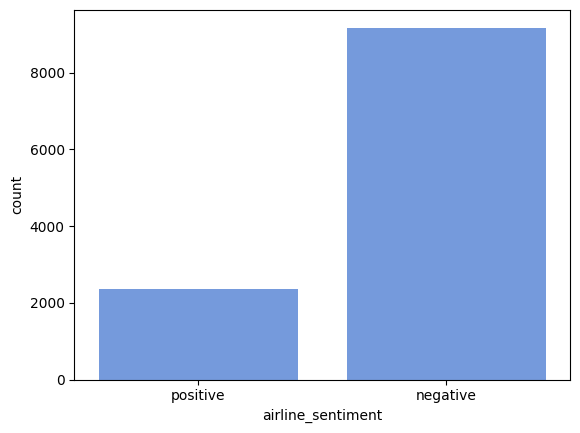

In [9]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

¡Parece que la mayoría de los tweets en este dataset expresan sentimiento negativo!

Veamos qué recibe más retweets:

In [10]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

¡Claramente los tweets negativos son retuiteados más frecuentemente que los positivos!

Veamos qué aerolínea recibe más tweets negativos:

In [11]:
# Get the proportion of negative tweets by airline
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


¡Parece que las personas están más insatisfechas con US Airways, seguida por American Airlines, ambas con más del 85% de tweets negativos!

Se podrían hacer muchos descubrimientos interesantes si quisieras explorar más los datos. Ahora volvamos a nuestra tarea de análisis de sentimientos. Pero antes, necesitamos preprocesar los datos de texto para que tengan un formato estándar.

<a id='section2'></a>
# Preprocesamiento

Dedicamos gran parte de la Parte 1 a aprender cómo preprocesar datos. ¡Apliquemos lo aprendido! Al observar algunos de los tweets anteriores, podemos ver que aunque están en buen estado, podemos hacer algún procesamiento adicional sobre ellos.

En nuestro pipeline, omitiremos el proceso de tokenización ya que lo realizaremos en un paso posterior.

## 🥊 Desafío 1: Aplicar un Pipeline de Limpieza de Texto

Escribe una función llamada `preprocess` que realice los siguientes pasos en un texto de entrada:

* Paso 1: Convertir el texto a minúsculas
* Paso 2: Reemplazar los siguientes patrones con placeholders:
    * URLs → ` URL `
    * Dígitos → ` DIGIT `
    * Hashtags → ` HASHTAG `
    * Menciones de usuario → ` USER `
* Paso 3: Eliminar espacios en blanco adicionales

Aquí hay algunas pistas para guiarte en este desafío:

* Para el Paso 1, recuerda de la Parte 1 que puedes usar el método [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) para convertir texto a minúsculas
* Hemos integrado el Paso 2 en una función llamada `placeholder`. Ejecuta la celda siguiente para importarla a tu notebook y podrás usarla como cualquier otra función
* Para el Paso 3, hemos proporcionado el patrón regex para identificar caracteres de espacio en blanco, así como el reemplazo correcto para eliminar espacios adicionales

Ejecuta tu función `preprocess` en `example_tweet` (tres celdas más abajo) para verificar si funciona. Si es correcto, aplícala a toda la columna `text` del dataframe de tweets

In [12]:
from utils import placeholder

/workspaces/Python-Text-Analysis/lessons/utils.py:4: SyntaxWarning: invalid escape sequence '\d'
  digit_pattern = '\d+'
/workspaces/Python-Text-Analysis/lessons/utils.py:14: SyntaxWarning: invalid escape sequence '\d'
  digit_pattern = '\d+'


In [13]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''

    # Step 1: Lowercase
    text = text.lower()

    # Step 2: Replace patterns with placeholders
    text = placeholder(text)

    # Step 3: Remove extra whitespace characters
    text = re.sub(blankspace_pattern, blankspace_repl, text)
    text = text.strip()
    
    return text

In [14]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

# Print the example tweet
print(example_tweet)
print(f"{'='*50}")

# Print the preprocessed tweet
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


In [15]:
# Apply the function to the text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    USER plus you've added commercials to the expe...
1    USER it's really aggressive to blast obnoxious...
2        USER and it's a really big bad thing about it
3    USER seriously would pay $ DIGIT a flight for ...
4    USER yes, nearly every time i fly vx this “ear...
Name: text_processed, dtype: object

¡Felicidades! El preprocesamiento está listo. ¡Adentrémonos en el bag-of-words!


# Representación Bag-of-Words (Bolsa de Palabras)

La idea detrás de **Bag-of-Words (BoW)**, como sugiere su nombre, es bastante intuitiva: tomamos un documento y lo "lanzamos" en una bolsa. Al hacerlo, ignoramos la posición relativa entre las palabras. Es decir, lo que queda "en la bolsa" es esencialmente un **conjunto desordenado de palabras** [(Jurafsky & Martin, 2024)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf).

A cambio, obtenemos:
- Una lista de palabras únicas.
- La frecuencia de cada palabra.

Por ejemplo, como se muestra en la ilustración a continuación, la palabra "coffee" aparece dos veces. 

![Ilustración Bag-of-Words](../images/bow-illustration-1.png)

Con una representación Bag-of-Words, utilizamos con fuerza la **frecuencia de palabras**, pero no tanto el **orden de las palabras**.

### Bag-of-Words en el Análisis de Sentimientos
En el contexto del análisis de sentimientos, el sentimiento de un texto (por ejemplo, un tweet) suele transmitirse más fuertemente por palabras específicas. Por ejemplo:
- Si un tweet contiene la palabra **"happy"**, probablemente transmita un sentimiento positivo.
- Sin embargo, no siempre es así. Por ejemplo, **"not happy"** expresa lo opuesto.

Cuando estas palabras específicas aparecen con mayor frecuencia, probablemente tendrán un impacto más fuerte en el análisis del sentimiento.


## Document Term Matrix (Matriz de Términos por Documento)

Ahora implementemos la idea de **Bag-of-Words**. Antes de profundizar, tomemos un momento para contextualizar. En la práctica, el análisis de texto generalmente implica trabajar con múltiples documentos. A partir de ahora, utilizaremos el término **documento** para referirnos a cualquier pieza de texto en la que realicemos análisis. Puede ser una frase, una oración, un tweet o cualquier otro texto—siempre que pueda representarse como una cadena de texto, la longitud no importa.

### Concepto
Imaginemos que tenemos cuatro documentos (es decir, las cuatro frases mostradas arriba) y los colocamos todos en la "bolsa". En lugar de obtener una lista de frecuencias de palabras, obtendremos una **matriz de términos por documento (DTM, por sus siglas en inglés)**.

En una DTM:
- La lista de palabras únicas (el **vocabulario**, \( V \)) contiene todas las palabras que aparecen en todos los documentos.
- Para cada **documento** (\( D \)), contamos cuántas veces aparece cada palabra del vocabulario en el documento y colocamos estos valores en la matriz.

En otras palabras, la DTM que construiremos es una matriz de \( D \times V \), donde:
- Cada **fila** corresponde a un documento.
- Cada **columna** corresponde a un token (o término único).

### Ejemplo
En el siguiente ejemplo, los tokens únicos de este conjunto de documentos se ordenan alfabéticamente para formar las columnas. Para cada documento, marcamos la ocurrencia de cada palabra presente. La representación numérica de cada documento es una fila en la matriz.

Por ejemplo, el primer documento, *"the coffee roaster"*, tiene la representación numérica:  
\[
[0, 1, 0, 0, 0, 1, 1, 0]
\]

A continuación, se muestra la matriz completa:

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\ 
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\ 
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\ 
\end{array}
$$

> **Nota**: Aunque la primera columna de la matriz muestra los documentos como texto, típicamente se les asignaría un índice numérico.

### Construcción de una DTM
Para crear una matriz de términos por documento, utilizaremos la clase `CountVectorizer` del paquete `sklearn`.



In [16]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustración muestra el flujo de trabajo de tres pasos para crear un **DTM** (*Document-Term Matrix*) con `CountVectorizer`.

![CountVectorizer](../images/CountVectorizer1.png)

### Vamos a recorrer estos pasos con el ejemplo de juguete que se muestra arriba.


### Un ejemplo Sencillo 

In [17]:
# A toy example containing four documents
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto `CountVectorizer`. Dentro de los paréntesis, podemos especificar configuraciones de parámetros si lo deseamos. Echemos un vistazo a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para ver qué opciones están disponibles.

Por ahora, podemos dejarlo en blanco para usar la configuración predeterminada.
 

In [18]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

El segundo paso es aplicar `fit` a este objeto `CountVectorizer` con los datos, lo que significa crear un vocabulario de tokens a partir del conjunto de documentos. En tercer lugar, utilizamos `transform` para transformar nuestros datos según el objeto `CountVectorizer` "ajustado", lo que implica tomar cada documento y contar las ocurrencias de tokens de acuerdo con el vocabulario establecido durante el paso de "ajuste".

Puede sonar un poco complejo, pero los pasos 2 y 3 se pueden realizar en un solo paso utilizando la función `fit_transform`.


In [19]:
# Fit and transform to create a DTM
test_count = vectorizer.fit_transform(test)

El resultado de `fit_transform` se supone que es el DTM (Documento-Termino Matriz).

¡Vamos a echarle un vistazo!


In [20]:
test_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (4, 8)>

Aparentemente, tenemos una "matriz dispersa", que es una matriz que contiene muchos ceros. Esto tiene sentido. Para cada documento, hay palabras que no aparecen en absoluto, y estas se cuentan como ceros en el DTM. Esta matriz dispersa se almacena en un formato "Compressed Sparse Row" (Fila Dispersa Comprimida), un formato diseñado para ahorrar memoria al manejar matrices dispersas.

Convirtámosla a una matriz densa, donde probablemente se representen esos ceros, como en un array de numpy.


In [21]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¡Así que este es nuestro DTM! La matriz es la misma que se muestra arriba. Para hacerla más fácil de leer, convirtámosla en un dataframe. Los nombres de las columnas deben ser los tokens del vocabulario, que podemos acceder con la función `get_feature_names_out`.


In [22]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [23]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¡Aquí está! El DTM de nuestros datos de prueba ahora es un dataframe. El índice de `test_dtm` corresponde a la posición de cada documento en la lista `test`.


In [24]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Esperamos que este ejemplo básico proporcione una guía clara sobre cómo crear un DTM.

Ahora es el momento de trabajar con nuestros datos de tweets.

### DTM para Tweets

Comenzaremos inicializando un objeto `CountVectorizer`. En la siguiente celda, hemos incluido algunos parámetros que a menudo se ajustan. Estos parámetros están actualmente configurados con sus valores predeterminados.

Al construir un DTM, el valor predeterminado es convertir el texto de entrada a minúsculas. Si no se proporciona nada para `stop_words`, el valor predeterminado es mantenerlas. Los siguientes tres parámetros se utilizan para controlar el tamaño del vocabulario, a los cuales volveremos en un momento.


In [25]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [26]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 191139 stored elements and shape (11541, 8751)>

In [27]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11541, 8751))

In [28]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [29]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos el `CountVectorizer` con la configuración predeterminada, el tamaño del vocabulario de los datos de tweets es de 8751.


In [30]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadv,aadvantage,aal,aaron,ab,aback,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La mayoría de los tokens tienen al menos cero ocurrencias, al menos en los primeros cinco tweets.

¡Echemos un vistazo más de cerca al DTM!


In [31]:
# Most frequent tokens
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

In [32]:
# Least frequent tokens
first_dtm.sum().sort_values(ascending=True).head(10)

zones         1
accelerate    1
acc           1
acarl         1
yogurt        1
yoga          1
yikes         1
absurdity     1
absorber      1
absorb        1
dtype: int64

No es sorprendente ver que "user" y "digit" estén entre los tokens más frecuentes, ya que reemplazamos cada uno de ellos con estos marcadores de posición. El resto de los tokens más frecuentes son principalmente palabras vacías (stop words).

Tal vez un patrón más interesante sea buscar qué token aparece más en un tweet dado:


In [33]:
counts = pd.DataFrame()

# Retrieve the index of the tweet where a token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurrence 
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
counts[(counts['token']!='digit')
       & (counts['token']!='hashtag')
       & (counts['token']!='user')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
11007,to,5
5513,to,5
7750,to,5
10923,the,5
4089,to,5
8134,to,5
8148,the,5
557,to,5


Parece que entre todos los tweets, como máximo, un token aparece seis veces, y es la palabra "It" o la palabra "worst."

Volvamos a nuestro dataframe de tweets y localicemos el tweet número 918.


In [34]:
# Retrieve 918th tweet: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Personalizar el `CountVectorizer`

Hasta ahora siempre hemos utilizado la configuración predeterminada de los parámetros para crear nuestros DTM, pero en muchos casos es posible que queramos personalizar el objeto `CountVectorizer`. El propósito de hacerlo es filtrar aún más los tokens innecesarios. En el siguiente ejemplo, ajustamos los siguientes parámetros:

- `stop_words = 'english'`: ignorar las palabras vacías en inglés
- `min_df = 2`: ignorar las palabras que no ocurren al menos dos veces
- `max_df = 0.95`: ignorar las palabras si aparecen en más del 95% de los documentos

🔔 **Pregunta**: ¡Paremos un minuto para discutir si suena razonable establecer estos parámetros! ¿Qué opinas?

A menudo, no nos interesan las palabras cuya frecuencia es demasiado baja o demasiado alta, por lo que utilizamos `min_df` y `max_df` para filtrarlas. Alternativamente, podemos definir el tamaño de nuestro vocabulario como $N$ al establecer `max_features`. En otras palabras, le decimos a `CountVectorizer` que solo considere los $N$ tokens más frecuentes al construir el DTM.


In [35]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [36]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestro segundo DTM tiene un vocabulario sustancialmente más pequeño en comparación con el primero.


In [37]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [38]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La lista de tokens más frecuentes ahora incluye palabras que tienen más sentido para nosotros, como "cancelled" y "service".


In [39]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

## 🥊 Reto 2: Lematizar el Texto de Entrada

Recuerda que en la Parte 1 introdujimos el uso de `spaCy` para realizar la lematización, es decir, para "recuperar" la forma base de una palabra. Este proceso reducirá el tamaño del vocabulario al mantener al mínimo las variaciones de las palabras; un vocabulario más pequeño puede ayudar a mejorar el rendimiento del modelo en la clasificación de sentimientos.

Ahora vamos a implementar la lematización en nuestros datos de tweets y usar el texto lematizado para crear un tercer DTM.

Completa la función `lemmatize_text`. Requiere una entrada de texto y devuelve las lemas de todos los tokens.

Aquí tienes algunos consejos para guiarte en este reto:

- Paso 1: inicializa una lista para contener las lemas
- Paso 2: aplica el pipeline de `nlp` al texto de entrada
- Paso 3: itera sobre los tokens en el texto procesado y recupera la lema del token
    - PISTA: la lematización es una de las anotaciones lingüísticas que el pipeline de `nlp` hace automáticamente por nosotros. Podemos usar `token.lemma_` para acceder a la anotación.


In [40]:
# Import spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

In [41]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemma = []

    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(token.lemma_)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma


Vamos a aplicar la función al siguiente tweet de ejemplo primero.

In [42]:
# Apply the function to an example tweet
print(tweets.iloc[33]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[33]['text_processed']))

USER wow this just blew my mind
USER wow this just blow my mind


Y luego vamos a lematizar los datos de los tweets y guardar el resultado en una nueva columna text_lemmatized.

In [43]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

Ahora, con la columna text_lemmatized, vamos a crear un tercer DTM. La configuración de los parámetros es la misma que en el segundo DTM.

In [44]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 8751)
(11541, 4471)
(11541, 3571)


Vamos a imprimir los 10 tokens más frecuentes como de costumbre. Estos tokens ahora son lemas y sus cuentas también cambian después de la lematización.

In [46]:
# Get the most frequent tokens in the third DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digit       6927
flight      3951
hashtag     2633
thank       1453
hour        1134
cancel       949
service      939
delay        934
customer     902
time         860
dtype: int64

In [47]:
# Compared to the most frequent tokens in the second DTM
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

<a id='section4'></a>

# Frecuencia de términos - Frecuencia inversa de documentos

Hasta ahora, nos basamos en la frecuencia de palabras para obtener información sobre un documento. Esto supone que si una palabra aparece con más frecuencia en un documento, es más informativa. Sin embargo, esto no siempre es así. Por ejemplo, ya hemos eliminado las palabras vacías porque no son informativas, a pesar de que aparecen muchas veces en un documento. También sabemos que la palabra "vuelo" es una de las más frecuentes, pero no es tan informativa, ya que aparece en muchos documentos. Dado que estamos analizando tweets de aerolíneas, no debería sorprendernos ver la palabra "vuelo".

Para solucionar esto, utilizamos un esquema de ponderación llamado **tf-idf (término frecuencia-inversa frecuencia** de documento). La idea principal de tf-idf es ponderar una palabra no solo por su frecuencia dentro de un documento, sino también por su frecuencia en un documento en relación con los demás. Por lo tanto, al construir el DTM, asignaremos a cada término un **tf-idf score**. Específicamente, al término $t$ del documento $d$ se le asigna un **tf-idf score** de la siguiente manera:

<img src='../images/tf-idf_finalized.png' alt="TF-IDF" width="1200">

En esencia, la puntuación **tf-idf** de una palabra en un documento es el producto de dos componentes: la frecuencia de término (tf) y la frecuencia inversa de documento (idf). La idf actúa como un factor de escala. Si una palabra aparece en todos los documentos, la idf es igual a 1. No se produce escala. Sin embargo, la idf suele ser mayor que 1, que es el peso que asignamos a la palabra para aumentar la puntuación **tf-idf** y destacar su carácter informativo. 

En la práctica, sumamos 1 tanto al denominador como al numerador (add-1 smooth) para evitar problemas con cero ocurrencias. También podemos crear un DTM tf-idf usando sklearn. En esta ocasión, usaremos **TfidfVectorizer**:

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [50]:
# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 87904 stored elements and shape (11541, 3571)>

In [51]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
            columns=vectorizer.get_feature_names_out(),
            index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Quizás hayas notado que el tamaño del vocabulario es el mismo que vimos en el Desafío 2. Esto se debe a que usamos la misma configuración de parámetros al crear la vectorización. Sin embargo, los valores de la matriz son diferentes: son puntuaciones de tf-idf en lugar de conteos brutos.

## Interpretar valores de TF-IDF

Analicemos el documento donde un término tiene los valores de tf-idf más altos. Usaremos el método .idxmax() para encontrar el índice.

Por ejemplo, el término "peor" aparece de forma más clara en el tweet número 918th. 

In [52]:
# Retrieve the index of the document
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aal           10630
abandon        7859
              ...  
yyz            1350
zero           2705
zone           3177
zoom           3920
zurich        10622
Length: 3571, dtype: int64

In [53]:
tfidf.idxmax()['worst']

np.int64(918)

¡Recordemos que este es el tweet donde la palabra “peor” aparece seis veces!

In [54]:
tweets['text_processed'].iloc[918]

"USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

¿Qué tal "Cancelar"? Veamos otro ejemplo.

In [55]:
tfidf.idxmax()['cancel']

np.int64(5945)

In [56]:
tweets['text_processed'].iloc[5945]

'USER cancelled flighted 😢'

## 🥊 Desafío 3: Palabras con las puntuaciones medias más altas en TF-IDF

Hemos obtenido valores **tf-idf** para cada término en cada documento. Pero ¿qué nos dicen estos valores sobre el sentimiento de los tweets? ¿Hay palabras que sean especialmente informativas para los tweets positivos/negativos?
Para explorar esto, recopilemos los índices de todos los tweets positivos/negativos y calculemos la media de las puntuaciones **tf-idf** de las palabras que aparecen en cada categoría.

Hemos proporcionado el siguiente código de inicio como guía:

*	Cree un subconjunto del dataframe de tweets según la etiqueta airline_sentiment y recupere el índice de cada subconjunto (.index). Asigne el índice a **positive_index** o a **negative_index**.
*	Para cada subconjunto:
-	Recupere la representación **td-idf**
-	Tome la media de los valores **tf-idf** del subconjunto con .mean()
-	Ordene la media de los valores **tf-idf** en orden descendente con .sort_values()
-	Obtenga los 10 términos principales con .head()

A continuación, ejecute pos.plot y neg.plot para representar gráficamente las palabras con las puntuaciones medias tf-idf más altas para cada subconjunto.


In [57]:
# Complete the boolean masks 
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

In [58]:
# Complete the following two lines
pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

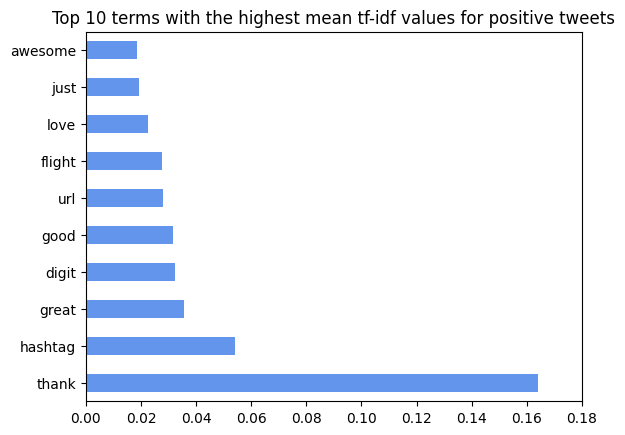

In [59]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

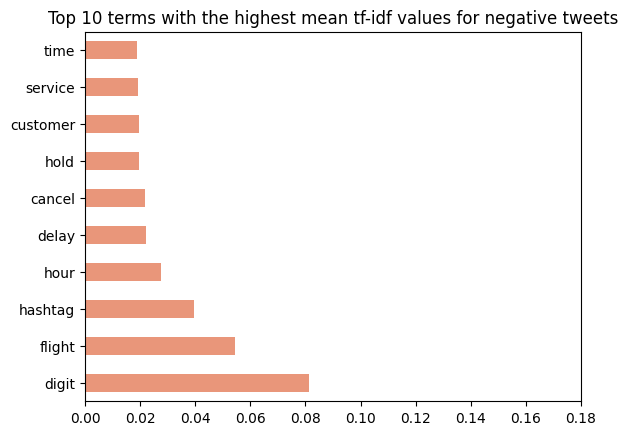

In [60]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

🔔 **Pregunta:** ¿Cómo interpretarías estos resultados? ¡Comparte tu opinión en el chat!

<a id='section5'></a>

## 🎬 **Demostración**: Clasificación de sentimientos mediante la representación TF-IDF

Ahora que tenemos una representación tf-idf del texto, ¡estamos listos para realizar el análisis de sentimiento!

En esta demostración, utilizaremos un modelo de regresión logística para realizar la tarea de clasificación. Aquí veremos brevemente cómo funciona la regresión logística como uno de los métodos supervisados de Aprendizaje Automático, pero no dudes en explorar nuestro taller sobre [Python Machine Learning Fundamentals](https://github.com/dlab-berkeley/Python-Machine-Learning) si quieres aprender más sobre ello.

La regresión logística es un modelo lineal, con el que predecimos la etiqueta de un tweet, basándonos en un conjunto de características ($x_1, x_2, x_3, ..., x_i$), como se muestra a continuación::

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

La lista de características que pasaremos al modelo es el vocabulario del DTM. También alimentamos el modelo con una parte de los datos, conocida como conjunto de entrenamiento, junto con otras especificaciones del modelo, para aprender el coeficiente ($\beta_1, \beta_2, \beta_3, ..., \beta_i$) de cada característica. Los coeficientes nos indican si una característica contribuye positiva o negativamente al valor predicho. El valor predicho corresponde a la suma de todas las características (multiplicadas por sus coeficientes), y el valor predicho se pasa a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) para convertirlo en el espacio de probabilidad, que nos dice si la etiqueta predicha es positiva (when $p>0.5$) o negativa (when $p<0.5$). 

La parte restante de los datos, conocida como conjunto de prueba, se utiliza para comprobar si los coeficientes aprendidos pueden generalizarse a datos no vistos. 

Ahora que ya tenemos el marco de datos tf-idf, el conjunto de características está listo. Pasemos a la especificación del modelo.

In [61]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

Utilizaremos la función `train_test_split` de `sklearn` para separar nuestros datos en dos conjuntos:

In [62]:
# Train-test split
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

La función `fit_logistic_regression` se escribe a continuación para agilizar el proceso de entrenamiento.

In [63]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

Ajustaremos el modelo y calcularemos la precisión de entrenamiento y de prueba.

In [64]:
# Fit the logistic regression model
model = fit_logistic_regression(X_train, y_train)

In [65]:
# Get the training and test accuracy
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9457640941992048
Test accuracy: 0.8885681293302541


El modelo alcanzó una precisión del 94% en el conjunto de datos de entrenamiento y del 89% en el conjunto de datos de prueba. El modelo se generaliza razonablemente bien a los datos de prueba.

A continuación, echemos también un vistazo a los coeficientes ajustados para ver si lo que vemos tiene sentido. 

Podemos acceder a ellos utilizando `coef_`, y podemos hacer coincidir cada coeficiente con los tokens del vectorizador:

In [66]:
# Get coefs of all features
coefs = model.coef_.ravel()

# Get all tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [67]:
# Get the top 10 tokens with lowest coefs
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

,token,coefs
2734,rude,-11.134836
2737,ruin,-10.012796
2797,screw,-9.478227
1143,fail,-9.347027
1513,hour,-7.996111
1521,hrs,-7.987312
1419,hang,-7.764156
3049,strand,-7.667356
2555,rebook,-7.617574
2287,pay,-7.460845


In [68]:
# Get the top 10 tokens with highest coefs
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef 

,token,coefs
1869,love,8.098307
1099,exceptional,8.572521
2636,replying,8.875486
1380,great,9.028898
114,amazing,9.221185
1097,excellent,9.279560
3515,wonderful,10.350372
250,awesome,10.550572
1752,kudo,12.033783
3179,thank,16.761327


Veamos las 10 fichas con los coeficientes más altos/bajos. 

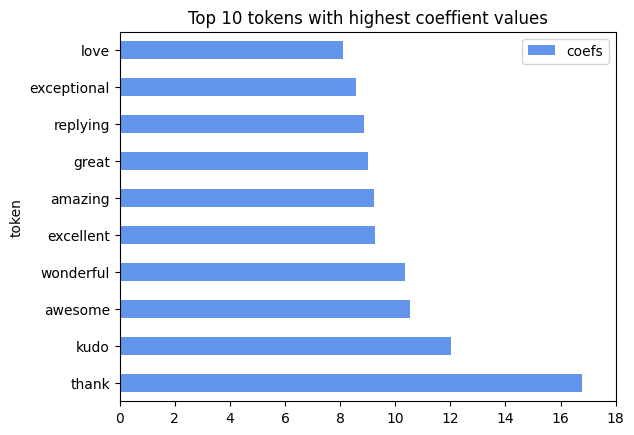

In [69]:
# Plot the top 10 tokens that have the highest coefs
pos_coef.sort_values('coefs', ascending=False) \
        .plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

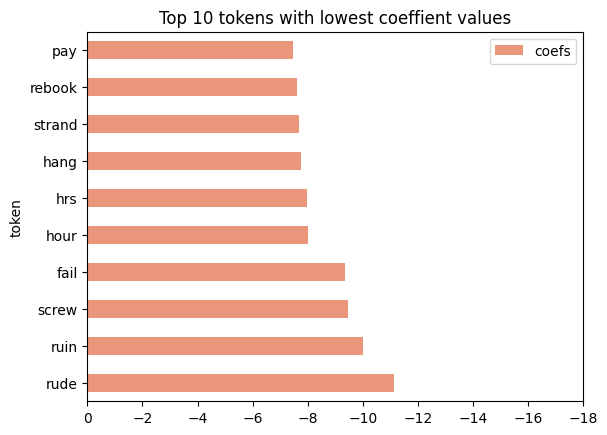

In [70]:
# Plot the top 10 tokens that have the lowest coefs
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

Palabras como "ruin," "rude," y "hour" son fuertes indicadores de un sentimiento negativo, mientras que "thank," "awesome," y "wonderful" » se asocian a un sentimiento positivo. 

Terminaremos la Parte 2 con estos gráficos. Estos términos de coeficiente y las palabras con los valores TF-IDF más altos ofrecen diferentes perspectivas sobre el sentimiento de los tweets. Si lo desea, tómese su tiempo para comparar los dos conjuntos de gráficos y ver cuál de ellos proporciona una mejor descripción de los sentimientos transmitidos en los tweets.

<div class="alert alert-success">

## ❗ Puntos clave

* Una representación de bolsa de palabras es un método sencillo para transformar los datos de texto en números. Se centra en la frecuencia de las palabras, pero no en su orden. 
* Una representación TF-IDF va un paso más allá; también tiene en cuenta si una determinada palabra aparece de forma distintiva en un documento o de manera uniforme en todos los documentos.  
* Con una representación numérica, podemos realizar una serie de tareas de clasificación de textos, como el análisis de sentimientos. 

</div>